# ModernBert with Counterfactual Training Data

The purpose of this notebook is to train a ModernBert model for sequence classification on the counterfactual augmented dataset from notebook 3.

>[Setup](#scrollTo=vNosm-CdsfHV)

>[Tokenize counterfactual train inputs](#scrollTo=B0kOk0Oosczw)

> [Functions](#scrollTo=gWfol5MkL26x)

>[Train ModernBert on CDA data](#scrollTo=sRVVwYX-zKWO)

>> [Save CDA trained ModernBert to drive](#scrollTo=NIDQel_o2fOm)

>> [Evaluate CDA Model Metrics](#scrollTo=qf-zudvaNPet)


---

**CDA Model evaluation findings**

After training ModernBert on the augmented dataset, we see slight decreases in the true positive gap between males and females for certain professions. Compared to the baseline gap of 19% for the dj profession, the CDA model shows only a 17% gap in favor of males. We also see more drastic decreases in the true positive gap for stereotypically female professions. For example, the baseline produced an 18% true positive rate gap for the dietition profession, which has now been reduced to only 9%. This has all been accomplished without sacrificing accuracy and overall F1 metrics, which still stand at 86% and 0.8138, respectively.


## Setup

In [1]:
# Install dependencies
!pip install -q transformers
!pip install -q datasets
!pip install -q peft

In [2]:
# Install libraries
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import json

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

from datasets import load_from_disk

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from functools import partial

In [3]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab-Notebooks/jordan-cda'

Mounted at /content/drive


#### Load counterfactual dataset (long version)

In [4]:
# Load counterfactual dataset
train_cf = load_from_disk(path + '/data_counterfactual/train_cf_long')

In [5]:
# Confirm load
print(f'CF train shape: {train_cf.shape}') # should be (514956, 4)

CF train shape: (514956, 4)


In [6]:
print(train_cf)

Dataset({
    features: ['profession', 'text_type', 'text', 'gender'],
    num_rows: 514956
})


#### Load tokenized dev inputs

In [4]:
# Load tokenized dev inputs
mbert_dev_inputs = load_from_disk(path + '/data_tokenized_inputs/mbert_dev_inputs')

In [5]:
# Confirm dev inputs load
print(f'Dev inputs shape: {mbert_dev_inputs.shape}') # should be (39642, 5)

Dev inputs shape: (39642, 5)


In [6]:
print(mbert_dev_inputs)

Dataset({
    features: ['hard_text', 'labels', 'gender', 'input_ids', 'attention_mask'],
    num_rows: 39642
})


#### Load model

In [7]:
# Set number of classes for classification
num_classes = 28

In [21]:
mbert = "answerdotai/ModernBERT-base"

In [ ]:
# Load ModernBert
mbert_model = AutoModelForSequenceClassification.from_pretrained(mbert, num_labels= num_classes)

In [22]:
# Load tokenizer
mbert_tokenizer = AutoTokenizer.from_pretrained(mbert)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

## Functions

In [8]:
BATCH_SIZE = 32

In [9]:
MAX_LENGTH = 512

In [10]:
# Map professions to their label for plotting
professions = ['accountant', 'architect','attorney','chiropractor','comedian',
               'composer','dentist','dietitian','dj','filmmaker',
               'interior_designer','journalist','model','nurse','painter',
               'paralegal','pastor','personal_trainer','photographer','physician',
               'poet','professor','psychologist','rapper','software_engineer',
               'surgeon','teacher','yoga_teacher']

profession_map = {num:prof for num, prof in enumerate(professions)}

profession_map

{0: 'accountant',
 1: 'architect',
 2: 'attorney',
 3: 'chiropractor',
 4: 'comedian',
 5: 'composer',
 6: 'dentist',
 7: 'dietitian',
 8: 'dj',
 9: 'filmmaker',
 10: 'interior_designer',
 11: 'journalist',
 12: 'model',
 13: 'nurse',
 14: 'painter',
 15: 'paralegal',
 16: 'pastor',
 17: 'personal_trainer',
 18: 'photographer',
 19: 'physician',
 20: 'poet',
 21: 'professor',
 22: 'psychologist',
 23: 'rapper',
 24: 'software_engineer',
 25: 'surgeon',
 26: 'teacher',
 27: 'yoga_teacher'}

In [11]:
def compute_metrics(eval_pred, genders= None):
  """
  Computes evaluation metrics, including overall and gender-specific metrics.
  """
  preds, labels = eval_pred
  preds = np.argmax(preds, axis= 1)

  metrics = {
      'f1_macro': f1_score(labels, preds, average= 'macro'),
      'accuracy': accuracy_score(labels, preds),
      'conf_matrix_overall': confusion_matrix(labels, preds).tolist()
  }

  if genders is not None:
    for gender in np.unique(genders):
      mask = (genders == gender)
      cm = confusion_matrix(labels[mask], preds[mask])
      f1 = f1_score(labels[mask], preds[mask], average= 'macro')
      acc = accuracy_score(labels[mask], preds[mask])

      metrics[f'conf_matrix_{gender}'] = cm.tolist()
      metrics[f'f1_{gender}'] = f1
      metrics[f'accuracy_{gender}'] = acc

  return metrics

## Tokenize counterfactual train inputs

In [ ]:
def tokenize_inputs(batch):
  return mbert_tokenizer(batch['text'],
                         padding= True,
                         truncation= True,
                         max_length= MAX_LENGTH,
                         return_tensors='pt')

In [ ]:
mbert_train_cf_inputs = train_cf.map(tokenize_inputs, batched= True, batch_size= BATCH_SIZE)

Map:   0%|          | 0/514956 [00:00<?, ? examples/s]

In [ ]:
print(mbert_train_cf_inputs.shape) # should have 6 columns (original 4 + attention mask + input_ids)

(514956, 6)


In [ ]:
# Rename profession column to labels
mbert_train_cf_inputs = mbert_train_cf_inputs.rename_column('profession', 'labels')

In [ ]:
mbert_train_cf_inputs[0]

{'labels': 21,
 'text_type': 'hard_text',
 'text': 'He is also the project lead of and major contributor to the open source assembler/simulator "EASy68K." He earned a master’s degree in computer science from the University of Michigan-Dearborn, where he is also an adjunct instructor. Downloads/Updates',
 'gender': 0,
 'input_ids': [50281,
  1328,
  310,
  671,
  253,
  2199,
  1421,
  273,
  285,
  2201,
  24938,
  281,
  253,
  1527,
  2603,
  19308,
  254,
  16,
  3549,
  11699,
  346,
  38,
  1719,
  90,
  2358,
  44,
  449,
  754,
  12431,
  247,
  6303,
  457,
  84,
  4248,
  275,
  4382,
  5859,
  432,
  253,
  2499,
  273,
  11314,
  14,
  24723,
  6448,
  13,
  835,
  344,
  310,
  671,
  271,
  49816,
  30498,
  15,
  21578,
  84,
  16,
  5683,
  24275,
  50282,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  50283,
  

In [ ]:
# Saved tokenized counterfactuals to drive
mbert_train_cf_inputs.save_to_disk(path + '/data_tokenized_inputs/mbert_train_cf_inputs')

Saving the dataset (0/2 shards):   0%|          | 0/514956 [00:00<?, ? examples/s]

#### Reload tokenized counterfactuals

In [12]:
# Use this cell to reload counterfactuals if needed
mbert_train_cf_inputs = load_from_disk(path + '/data_tokenized_inputs/mbert_train_cf_inputs')

In [13]:
# Confirm load
print(f'Tokenized counterfactual train inputs shape: {mbert_train_cf_inputs.shape}')

mbert_train_cf_inputs

Tokenized counterfactual train inputs shape: (514956, 6)


Dataset({
    features: ['labels', 'text_type', 'text', 'gender', 'input_ids', 'attention_mask'],
    num_rows: 514956
})

In [14]:
# Rename text column to match mbert_train_cf_inputs
mbert_dev_inputs = mbert_dev_inputs.rename_column('hard_text', 'text')

In [15]:
mbert_dev_inputs

Dataset({
    features: ['text', 'labels', 'gender', 'input_ids', 'attention_mask'],
    num_rows: 39642
})

## Train ModernBert on CDA data

In [23]:
training_args = TrainingArguments(
    output_dir= path + '/models_trained/mbert_cda',
    save_strategy= 'epoch',
    eval_strategy= 'epoch',
    logging_strategy= 'epoch',
    per_device_train_batch_size= BATCH_SIZE,
    per_device_eval_batch_size= BATCH_SIZE,
    num_train_epochs= 3,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1_macro',
    report_to= 'none'
)

In [24]:
trainer = Trainer(
    model= mbert_model,
    args= training_args,
    train_dataset= mbert_train_cf_inputs,
    eval_dataset= mbert_dev_inputs,
    compute_metrics= partial(compute_metrics, genders = mbert_dev_inputs['gender']),
    data_collator= DataCollatorWithPadding(tokenizer=mbert_tokenizer) # Add data collator for dynamic padding
)

In [22]:
results = trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy,Conf Matrix Overall,Conf Matrix 0,F1 0,Accuracy 0,Conf Matrix 1,F1 1,Accuracy 1
1,0.416800,0.499000,0.813827,0.863075,"[[440, 12, 40, 0, 1, 0, 0, 0, 2, 2, 0, 12, 3, 5, 1, 2, 3, 0, 3, 1, 1, 16, 4, 0, 5, 0, 11, 0], [6, 768, 13, 0, 0, 2, 0, 0, 0, 2, 27, 16, 0, 4, 6, 0, 1, 0, 18, 2, 0, 40, 6, 0, 89, 0, 12, 0], [27, 10, 2998, 1, 4, 1, 0, 1, 1, 4, 1, 50, 12, 8, 1, 13, 6, 1, 3, 3, 1, 70, 13, 0, 3, 0, 26, 0], [1, 0, 1, 188, 0, 0, 3, 4, 0, 0, 0, 1, 0, 16, 0, 0, 0, 3, 0, 38, 0, 1, 1, 0, 0, 5, 3, 1], [0, 0, 4, 0, 236, 1, 0, 0, 2, 8, 1, 10, 8, 0, 1, 0, 1, 0, 3, 0, 2, 0, 0, 0, 0, 0, 5, 0], [0, 0, 0, 0, 3, 499, 0, 0, 11, 8, 0, 3, 0, 0, 2, 0, 1, 0, 2, 0, 7, 10, 0, 3, 1, 1, 10, 0], [0, 1, 2, 1, 1, 0, 1408, 1, 2, 0, 0, 4, 3, 3, 0, 0, 1, 0, 2, 7, 0, 2, 0, 0, 1, 13, 7, 0], [1, 0, 3, 0, 0, 0, 2, 346, 0, 0, 0, 4, 0, 8, 0, 0, 0, 5, 0, 4, 0, 11, 9, 0, 0, 1, 1, 1], [0, 1, 0, 0, 5, 4, 0, 0, 124, 0, 0, 5, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 3, 0, 0, 1, 2], [0, 1, 7, 0, 4, 4, 0, 0, 0, 612, 0, 22, 4, 1, 0, 0, 0, 0, 26, 3, 1, 10, 2, 0, 0, 0, 4, 0], [0, 15, 5, 0, 0, 0, 0, 0, 1, 0, 108, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 2, 1, 0, 0, 0, 5, 1], [3, 10, 41, 1, 9, 1, 0, 3, 7, 25, 4, 1636, 14, 13, 5, 0, 6, 2, 51, 8, 12, 61, 17, 1, 12, 2, 50, 1], [3, 8, 14, 0, 10, 2, 0, 0, 2, 4, 1, 15, 616, 10, 1, 0, 2, 3, 18, 2, 2, 11, 1, 3, 2, 1, 19, 0], [4, 3, 21, 3, 2, 0, 1, 9, 0, 3, 3, 8, 6, 1648, 1, 0, 5, 2, 0, 46, 4, 48, 22, 0, 1, 19, 33, 4], [1, 9, 5, 0, 3, 3, 0, 0, 0, 6, 1, 2, 2, 2, 651, 0, 0, 1, 65, 0, 5, 9, 0, 1, 0, 0, 8, 0], [2, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0], [2, 0, 7, 0, 1, 1, 0, 0, 0, 1, 0, 15, 2, 5, 1, 0, 175, 1, 0, 0, 1, 17, 7, 0, 1, 1, 15, 0], [0, 0, 1, 1, 0, 0, 1, 9, 1, 0, 0, 2, 6, 1, 0, 0, 0, 109, 3, 1, 0, 4, 0, 0, 0, 0, 4, 1], [3, 13, 15, 0, 6, 3, 0, 2, 5, 31, 1, 50, 9, 5, 36, 0, 2, 1, 2205, 2, 3, 9, 2, 1, 3, 2, 18, 1], [2, 4, 14, 40, 0, 0, 10, 11, 0, 2, 1, 11, 4, 111, 0, 1, 1, 1, 2, 3598, 4, 192, 25, 0, 0, 52, 13, 1], [2, 2, 3, 0, 3, 5, 0, 0, 3, 7, 0, 41, 0, 2, 5, 1, 5, 0, 9, 2, 513, 51, 4, 5, 1, 0, 38, 0], [7, 77, 74, 1, 3, 27, 14, 10, 1, 19, 1, 95, 3, 46, 23, 0, 16, 1, 28, 91, 19, 10984, 104, 0, 28, 52, 84, 0], [1, 5, 11, 3, 1, 0, 1, 4, 2, 1, 0, 34, 2, 22, 1, 0, 6, 1, 2, 14, 10, 199, 1453, 0, 4, 13, 47, 2], [0, 0, 1, 0, 4, 3, 0, 0, 9, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 119, 0, 0, 0, 0], [4, 62, 6, 0, 1, 1, 0, 0, 0, 2, 0, 6, 3, 0, 1, 0, 0, 1, 7, 0, 1, 50, 5, 1, 527, 0, 13, 1], [1, 2, 7, 3, 0, 1, 47, 0, 0, 0, 0, 1, 2, 8, 0, 0, 2, 0, 0, 269, 1, 67, 3, 0, 1, 943, 2, 0], [10, 12, 40, 3, 8, 15, 1, 3, 3, 11, 2, 70, 13, 25, 12, 3, 38, 4, 22, 3, 21, 196, 38, 2, 4, 1, 1043, 18], [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1, 15, 143]]","[[277, 9, 28, 0, 0, 0, 0, 0, 1, 1, 0, 9, 1, 2, 1, 1, 3, 0, 2, 1, 1, 9, 2, 0, 3, 0, 6, 0], [4, 586, 8, 0, 0, 2, 0, 0, 0, 1, 16, 11, 0, 3, 6, 0, 1, 0, 13, 2, 0, 25, 4, 0, 82, 0, 8, 0], [16, 8, 1848, 1, 3, 0, 0, 1, 1, 3, 0, 35, 6, 2, 1, 5, 4, 1, 2, 3, 1, 50, 6, 0, 1, 0, 12, 0], [0, 0, 1, 141, 0, 0, 2, 3, 0, 0, 0, 1, 0, 5, 0, 0, 0, 2, 0, 32, 0, 1, 1, 0, 0, 5, 2, 0], [0, 0, 4, 0, 181, 1, 0, 0, 2, 6, 1, 9, 6, 0, 1, 0, 1, 0, 3, 0, 2, 0, 0, 0, 0, 0, 5, 0], [0, 0, 0, 0, 3, 416, 0, 0, 9, 8, 0, 3, 0, 0, 2, 0, 1, 0, 2, 0, 4, 10, 0, 1, 1, 1, 8, 0], [0, 1, 2, 0, 1, 0, 910, 0, 2, 0, 0, 2, 2, 2, 0, 0, 1, 0, 2, 5, 0, 1, 0, 0, 1, 7, 5, 0], [1, 0, 1, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 5, 4, 0, 0, 109, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 3, 0, 0, 0, 1], [0, 0, 6, 0, 3, 4, 0, 0, 0, 418, 0, 10, 1, 0, 0, 0, 0, 0, 16, 1, 1, 6, 1, 0, 0, 0, 3, 0], [0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 22, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 6, 28, 1, 8, 1, 0, 1, 4, 10, 1, 824, 4, 3, 2, 0, 6, 0, 25, 2, 5, 38, 3, 0, 10, 1, 23, 0], [2, 7, 8, 0, 5, 2, 0, 0, 1, 1, 0, 7, 65, 2, 1, 0, 2, 1, 3, 2, 2, 8, 1, 1, 2, 0, 7, 0], [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 142, 0, 0, 0, 

## Save CDA Model to drive

In [16]:
# Run this to set the file path
mbert_cda_checkpoint_filepath = path + '/models_trained/mbert_cda'

In [24]:
# Run this to save the model
mbert_model.save_pretrained(mbert_cda_checkpoint_filepath)

In [17]:
# Run this to reload model
mbert_model = AutoModelForSequenceClassification.from_pretrained(mbert_cda_checkpoint_filepath)

## Evaluate CDA Model Metrics

In [25]:
# Save metrics from epochs
eval_metrics = trainer.evaluate(mbert_dev_inputs)

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W1203 03:53:16.602000 2717 torch/_inductor/utils.py:1558] [1/0_1] Not enough SMs to use max_autotune_gemm mode


In [26]:
# Set filepath for metrics
metrics_filepath = path + '/models_trained/mbert_cda/eval_metrics.json'

In [27]:
# Save metrics to drive
with open(metrics_filepath, 'w') as f:
  json.dump(eval_metrics, f)

print(f'Evaluation metrics saved to: {metrics_filepath}')

Evaluation metrics saved to: /content/drive/MyDrive/Colab-Notebooks/jordan-cda/models_trained/mbert_cda/eval_metrics.json


In [ ]:
# Reload metrics if needed
with open(metrics_filepath, 'r') as f:
  eval_metrics = json.load(f)



---



In [28]:
# Print metrics for best model
print(f'Overall Accuracy: {round(eval_metrics["eval_accuracy"]*100,2)}%\n',
      f'Accuracy- Males: {round(eval_metrics['eval_accuracy_0']*100,2)}%\n',
      f'Accuracy-Females: {round(eval_metrics['eval_accuracy_1']*100,2)}%\n',
      f'\n',
      f'Overall F1-Macro: {round(eval_metrics['eval_f1_macro'],4)}\n',
      f'F1-Macro- Males: {round(eval_metrics['eval_f1_0'],4)}\n',
      f'F1-Macro- Females: {round(eval_metrics['eval_f1_1'],4)}')

Overall Accuracy: 86.31%
 Accuracy- Males: 85.96%
 Accuracy-Females: 86.71%
 
 Overall F1-Macro: 0.8138
 F1-Macro- Males: 0.7804
 F1-Macro- Females: 0.8015


In [29]:
# Normalize gendered confusion matrices
cmnorm_females = np.array(eval_metrics['eval_conf_matrix_1']) / np.array(eval_metrics['eval_conf_matrix_1']).sum(axis=1)
cmnorm_males = np.array(eval_metrics['eval_conf_matrix_0']) / np.array(eval_metrics['eval_conf_matrix_0']).sum(axis=1)

In [30]:
# Compute the true positive rates
tp_females = np.diag(cmnorm_females)
tp_males = np.diag(cmnorm_males)


In [31]:
# Create a dataframe to show difference between true positive rates
tp_data = {
    'Females': tp_females,
    'Males': tp_males
}

tp_df = pd.DataFrame(tp_data, index = professions)
tp_df['True Positive Difference'] = tp_df['Females'] - tp_df['Males']

In [32]:
tp_df.sort_values(by= 'True Positive Difference')

,Females,Males,True Positive Difference
dj,0.681818,0.851562,-0.169744
surgeon,0.574257,0.714162,-0.139905
interior_designer,0.728814,0.785714,-0.056901
filmmaker,0.839827,0.889362,-0.049535
chiropractor,0.671429,0.719388,-0.047959
photographer,0.892734,0.916720,-0.023986
professor,0.924521,0.934897,-0.010375
architect,0.758333,0.759067,-0.000734
attorney,0.921474,0.919403,0.002071
dentist,0.966990,0.963983,0.003007


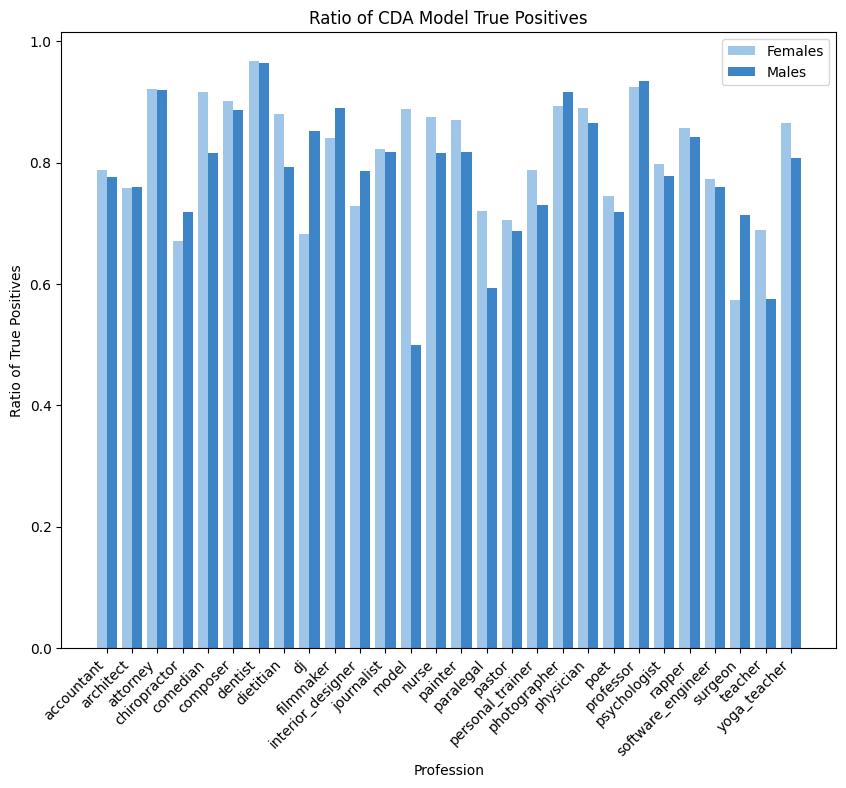

In [33]:
# Plot bar charts for true positives rates by gender and profession
w, x = 0.4, np.arange(len(professions))

fig, ax = plt.subplots(figsize= (10,8))
ax.bar(x - w/2, tp_females, width=w, label='Females', color = '#9fc5e8')
ax.bar(x + w/2, tp_males, width=w, label='Males', color = '#3d85c6')

ax.set_xticks(x) # Use set_xticks
ax.set_xticklabels(professions, rotation= 45, ha= 'right')
ax.set_xlabel('Profession')
ax.set_ylabel('Ratio of True Positives')
ax.set_title('Ratio of CDA Model True Positives')
ax.legend()

plt.show()